In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!unzip '/content/gdrive/MyDrive/Face Age/Dataset.zip' > /dev/null

replace 01/1000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [ ]:
import numpy as np                                                ###Importing the relevant libraries
import matplotlib.pyplot as plt
import pandas as pd
import os 
import cv2
from tqdm import tqdm
import sklearn
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

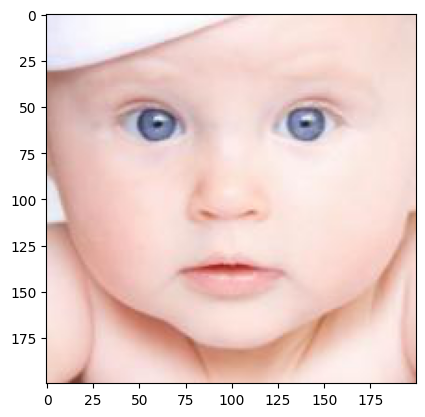

In [ ]:
DATADIR = r"/content"   
CATEGORIES = [('0'+str(i)) for i in range(1,93)]

for category in CATEGORIES:                                                              
    path = os.path.join(DATADIR,category)                        ###Directing the path of images and plotting the sample
    for img in os.listdir(path):
        im_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)
        plt.show
        break
    break

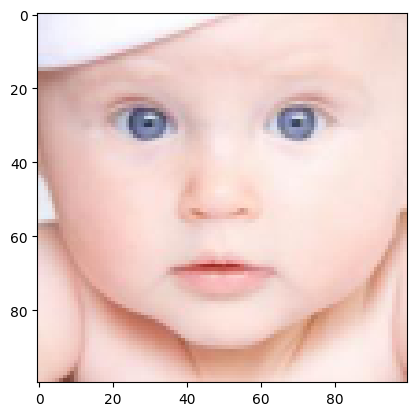

In [ ]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [ ]:
new_array.shape

(100, 100, 3)

In [ ]:
data = []

def create_training_data():
    for category in CATEGORIES: 
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category) 
        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), 3) 
                data.append([new_array, class_num])
            except Exception as e:  
                pass
            

create_training_data()

100%|██████████| 13/13 [00:00<00:00, 587.46it/s]


In [ ]:
import random
random.shuffle(data)

In [ ]:
X = []
y = []
for feature,label in data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)/255
y = np.array(y)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=666)

In [ ]:
X_train = X_train.reshape(-1,IMG_SIZE,IMG_SIZE,3)
X_test = X_test.reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [ ]:
Ymodel = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation = 'relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
          
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten()) 
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
          
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                        

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 20, factor = 0.1)
]

In [ ]:
model.fit(X_train,y_train, batch_size=64, epochs = 100, verbose = 1,
                    validation_split = 0.2, callbacks = my_callbacks)

Epoch 1/100


In [ ]:
model.predict(X_test)

61/61 [==============================] - 0s 7ms/step


array([[-0.05098337],
       [-0.03840361],
       [-0.04145498],
       ...,
       [-0.15622538],
       [-0.07399033],
       [-0.08294515]], dtype=float32)

In [ ]:
def metrics(true,predicted):
    return mean_squared_error(true, predicted), r2_score(true, predicted)

In [ ]:
y_test

array([ 9, 85,  2, ..., 61, 71,  1])

In [ ]:
preds

array([[-0.05098337],
       [-0.03840361],
       [-0.04145498],
       ...,
       [-0.15622538],
       [-0.07399033],
       [-0.08294515]], dtype=float32)

In [ ]:
metrics(y_test, preds)

(1479.5290785958964, -1.3297864621627884)

In [ ]:
def create_model(input_shape, optimizer='adam', fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    top_model = conv_base.output
    model = Flatten(name="flatten")(top_model)
    model = Dense(2048, activation='relu')(model)
    model = Dense(512, activation='relu')(model)
    output = Dense(1, activation='linear')(model)

    model = Model(inputs=conv_base.input, outputs=output)
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error')
    return model

In [ ]:
X_train.shape[0]

7799

In [ ]:
BATCH_SIZE=64
input_shape = X_train[0].shape
optim_1 = Adam(learning_rate=0.001)

n_steps =  X_train.shape[0] // BATCH_SIZE
n_epochs = 100

In [ ]:
vgg_model = create_model(input_shape, optim_1, fine_tune=0)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
! pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='/gdrive/MyDrive/Face Age/tl.hdf5',
                                  save_best_only=True,
                                  verbose=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           restore_best_weights=True,
                           mode='min')

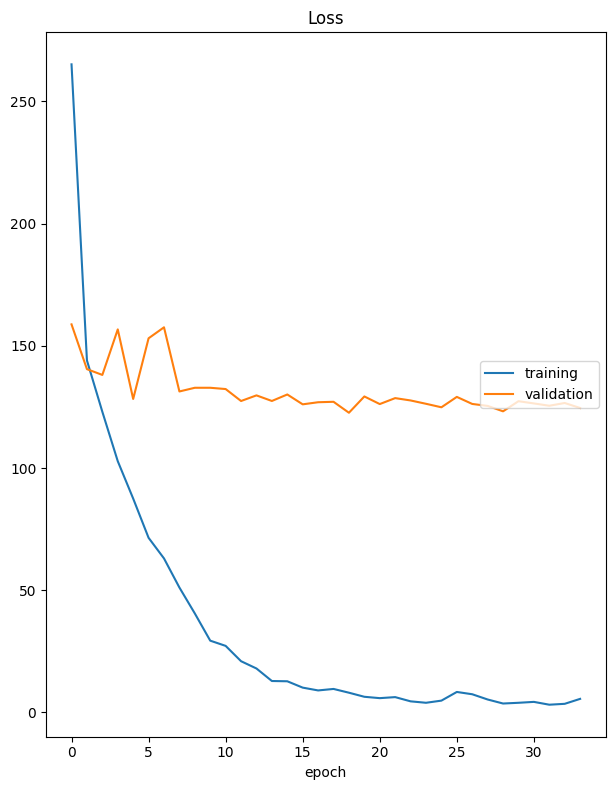

Loss
	training         	 (min:    3.162, max:  265.146, cur:    5.549)
	validation       	 (min:  122.609, max:  158.768, cur:  124.555)
121/121 [==============================] - 9s 77ms/step - loss: 5.5490 - val_loss: 124.5550
CPU times: user 1min 35s, sys: 25.3 s, total: 2min
Wall time: 5min 41s


In [ ]:
%%time
vgg_history = vgg_model.fit(X_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_split=0.2,
                            steps_per_epoch=n_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
vgg_preds = vgg_model.predict(X_test)

61/61 [==============================] - 4s 46ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
metrics(y_test, vgg_preds)

(130.51692846045756, 0.794477460829078)

In [ ]:
optim_2 = Adam(learning_rate=0.0001)
vgg_model_ft = create_model(input_shape, optim_2, fine_tune=3)

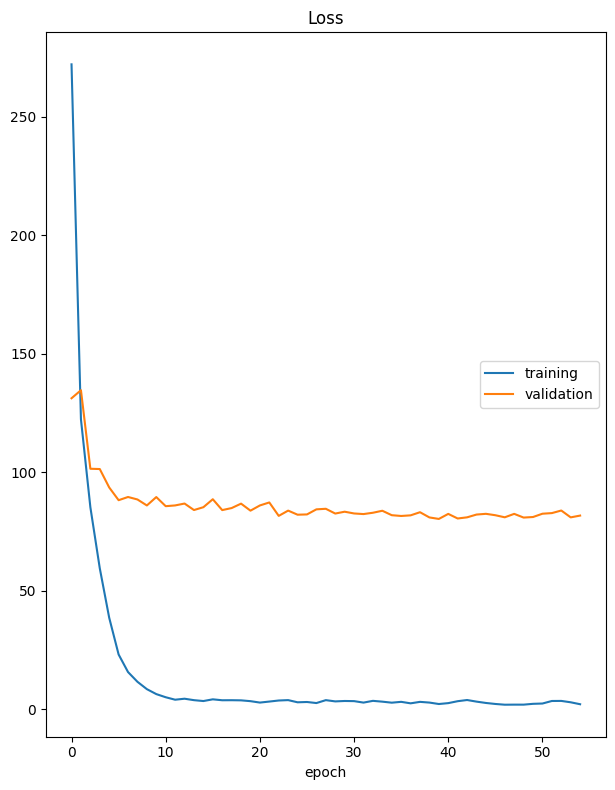

Loss
	training         	 (min:    1.873, max:  272.040, cur:    2.073)
	validation       	 (min:   80.251, max:  134.562, cur:   81.664)
121/121 [==============================] - 10s 85ms/step - loss: 2.0728 - val_loss: 81.6642
CPU times: user 3min 26s, sys: 38.6 s, total: 4min 5s
Wall time: 10min 3s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()
vgg_ft_history = vgg_model_ft.fit(X_train, y_train,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_split = 0.2,
                                  steps_per_epoch=n_steps, 
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
vgg_fine_preds = vgg_model_ft.predict(X_test)
metrics(y_test, vgg_fine_preds)

61/61 [==============================] - 2s 31ms/step


(84.63690282142743, 0.8667238696113478)

In [ ]:
from tensorflow.keras.applications import ResNet50
def create_model_resnet(input_shape, optim, fine_tune = 0):
    base_resnet_model = ResNet50(input_shape=X_train[0].shape, include_top=False, weights="imagenet")
    if fine_tune>0:
        for layer in base_resnet_model.layers[:165]:
            layer.trainable = False
        for layer in base_resnet_model.layers[165:]:
            layer.trainable = True
    else:
        for layer in base_resnet_model.layers:
            layer.trainable = False
    top_model = base_resnet_model.output
    model = Flatten(name='Flatten')(top_model)
    model = Dense(512, activation='relu')(model)
    output = Dense(1, activation='linear')(model)

    model = Model(inputs=base_resnet_model.input, outputs=output)
    model.compile(optimizer=optim, 
                  loss='mean_squared_error')
    return model

In [ ]:
t2_checkpoint_1 = ModelCheckpoint(filepath='/content/gdrive/MyDrive/Face Age/t2.hdf5',
                                  save_best_only=True,
                                  verbose=1)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
my_callbacks_res = [early_stopping, t2_checkpoint_1]

In [ ]:
BATCH_SIZE=64
input_shape = X_train[0].shape
optim_1 = Adam(learning_rate=0.001)

n_steps =  X_train.shape[0] // BATCH_SIZE
n_epochs = 50

In [ ]:
resnet_model = create_model_resnet(input_shape, optim_1, fine_tune=0)

In [ ]:
resnet_history = resnet_model.fit(X_train, y_train, validation_split = 0.15, steps_per_epoch = n_steps, epochs = 50,
                                  callbacks=my_callbacks_res)

In [ ]:
resnet_preds = resnet_model.predict(X_test)

61/61 [==============================] - 4s 41ms/step


In [ ]:
y_test

array([25,  0, 34, ..., 42, 34,  4])

In [ ]:
resnet_preds[0]

array([[[29.201883],
        [29.14912 ],
        [29.223743],
        [28.954586]],

       [[28.752964],
        [28.286814],
        [29.198473],
        [29.185276]],

       [[29.292747],
        [29.04965 ],
        [28.528257],
        [29.050354]],

       [[28.769867],
        [28.59996 ],
        [28.579205],
        [28.734768]]], dtype=float32)

In [ ]:
for layer in base_resnet_model.layers[:165]:
   layer.trainable = False
for layer in base_resnet_model.layers[165:]:
   layer.trainable = True

In [ ]:
resnet_model_fine = Sequential()
resnet_model_fine.add(base_resnet_model)
resnet_model_fine.add(Dense(512, activation='relu'))
resnet_model_fine.add(Dense(1, activation='linear'))

In [ ]:
resnet_model_fine.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [ ]:
t2_checkpoint_2 = ModelCheckpoint(filepath='/content/gdrive/MyDrive/Face Age/t2.hdf5',
                                  save_best_only=True,
                                  verbose=1)

In [ ]:
my_callbacks= [early_stopping, t2_checkpoint_2]

In [ ]:
resnet_fine_history = resnet_model_fine.fit(X_train, y_train, validation_split = 0.15, steps_per_epoch = 100, epochs = 50,
                                  callbacks=my_callbacks)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 688.6466
Epoch 1: val_loss improved from inf to 719.24670, saving model to /content/gdrive/MyDrive/Face Age/t2.hdf5
100/100 [==============================] - 27s 182ms/step - loss: 688.6466 - val_loss: 719.2467
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 600.3372
Epoch 2: val_loss improved from 719.24670 to 658.35913, saving model to /content/gdrive/MyDrive/Face Age/t2.hdf5
100/100 [==============================] - 9s 93ms/step - loss: 600.3372 - val_loss: 658.3591
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 595.7752
Epoch 3: val_loss improved from 658.35913 to 649.79120, saving model to /content/gdrive/MyDrive/Face Age/t2.hdf5
100/100 [==============================] - 9s 88ms/step - loss: 595.7752 - val_loss: 649.7912
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 596.9360
Epoch 4: val_loss improved from 649.79120 to 645.17017, saving mode

In [ ]:
resnet_model_fine.predict(X_test).shape

61/61 [==============================] - 2s 30ms/step


(1950, 4, 4, 1)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape = X_train[0].shape, include_top = False, weights = 'imagenet')

In [ ]:
for layer in inception_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='linear')(x)
incept_model = Model(inception_model.input, x)

incept_model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error')

In [ ]:
inc_history = incept_model.fit(X_train, y_train, validation_split = 0.1, steps_per_epoch = 100, epochs = 50,
                        callbacks=early_stopping)

In [ ]:
inception_preds = incept_model.predict(X_test)

In [ ]:
metrics(y_test, inception_preds)